In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [16]:
df = pd.read_csv('data/data_prep.csv')

In [3]:
sns.set()

# Preprocessing

### With all values or correlated values excluded

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('relevant', axis=1), df.relevant, 
    stratify=df.relevant, train_size=0.8, test_size=0.2, 
    random_state=42)

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Importance

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1)

k_fold = KFold(n_splits=10, shuffle=True, random_state=1)
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=-1, scoring='accuracy')
print(score)
score.mean()

[0.8296875  0.8328125  0.82578125 0.81953125 0.825      0.8421875
 0.828125   0.80390625 0.81860829 0.83189992]


0.8257539459538702

In [7]:
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1)

clf.fit(X_train, y_train) # Used for evaluation after
accuracy_score(y_test, clf.predict(X_test))

0.825

In [8]:
from sklearn.inspection import permutation_importance

rf_importance = clf.feature_importances_
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats = 10, random_state=1)
# rf_feature_names_encoded = model.named_steps['preprocess'].named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names(input_features=categorical)

feature_names = df.drop('relevant', axis=1).columns

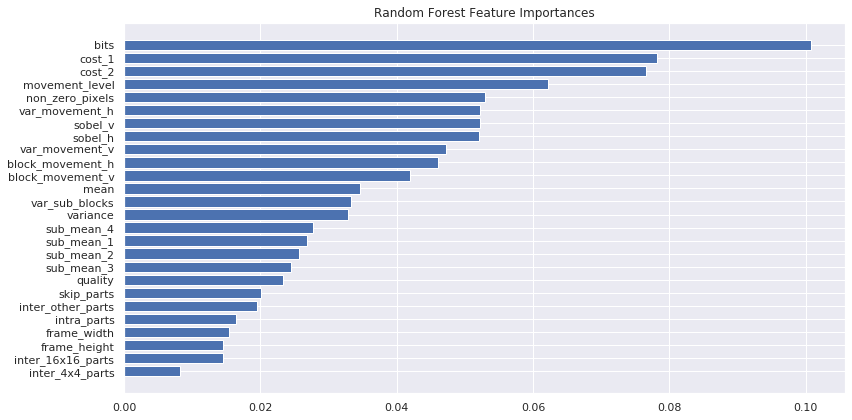

In [9]:
# Plot feature importances
features_to_display = 26
sorted_idx = rf_importance.argsort()[-features_to_display:]
fig, ax = plt.subplots(figsize=(12, 6))
y_ticks = np.arange(0, features_to_display)
ax.barh(y_ticks, rf_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")

fig.tight_layout()
fig.savefig('randomimportant.png')
plt.show()

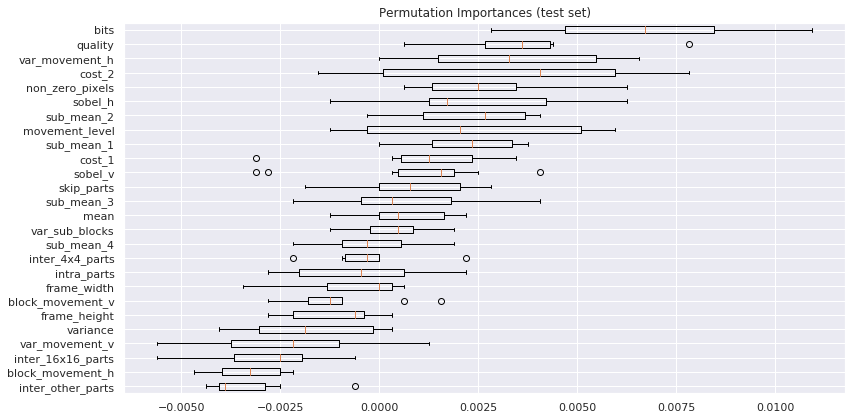

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_idx = perm_importance.importances_mean.argsort()
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")

fig.tight_layout()
fig.savefig('randomperm.png')
plt.show()

# Exploration #2

In [11]:
bits_mean = df['bits'].mean()
irrelevant = df[df['relevant'] == 0]
less_mean = irrelevant[irrelevant['bits']<bits_mean].shape[0]
print(100 * float(less_mean)/float(irrelevant.shape[0]),'% of the irrelevant blocks have bits which are less than the average bits number')

92.32934553131598 % of the irrelevant blocks have bits which are less than the average bits number


# Preprocessing #2

In [13]:
df = df.drop(['non_zero_pixels','frame_height','frame_width','sobel_v','inter_16x16_parts','inter_4x4_parts'],axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('relevant', axis=1), df.relevant, 
    stratify=df.relevant, train_size=0.8, test_size=0.2, 
    random_state=42)

In [18]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training 

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [20]:
use_knn=1
random_forest=1

## KNN

In [99]:
if use_knn:    
    from sklearn.neighbors import KNeighborsClassifier
    k_list = [10, 20, 30, 40, 100, 150]
    #k_list = range(40, 45)
    weight_list = ['uniform', 'distance']
    p_list = [1, 2]
    param_grid_knn = dict(n_neighbors=k_list, weights=weight_list, p=p_list)
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', error_score=np.nan, verbose=1,n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.score(X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.0s finished


{'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}
0.8271608782727627
0.829375


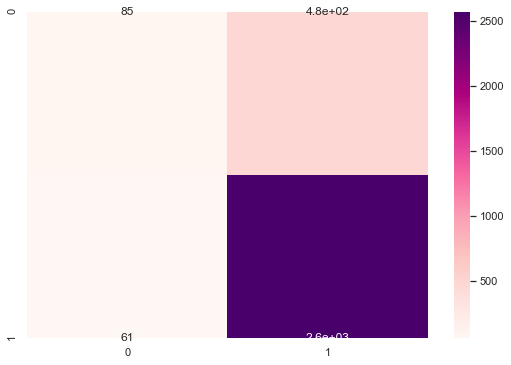

In [90]:
y_pred = grid.predict(X_test)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap='RdPu', annot=True, ax=ax)
plt.show()
#fig.savefig('knn.png')

## Random Forest

In [21]:
if random_forest:
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(random_state=0)
    crit = ["gini", "entropy"]
    estim = [30, 60, 100, 150]
    #estim = range(120, 131)  #--130
    bootstrap_list = [True, False]
    weights = ["balanced",None]
    param_grid_rfc = dict(n_estimators=estim,bootstrap=bootstrap_list,criterion=crit,class_weight=weights)
    grid = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring='accuracy', error_score=np.nan, verbose=1,n_jobs=7)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.score(X_test, y_test))
    

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   23.7s
[Parallel(n_jobs=7)]: Done 160 out of 160 | elapsed:  2.6min finished


{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 150}
0.8305200700957405
0.83125


In [22]:
rfc = RandomForestClassifier(**grid.best_params_,random_state=0)
rfc.fit(X_train,y_train)
rf_importance = rfc.feature_importances_
# rf_feature_names_encoded = model.named_steps['preprocess'].named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names(input_features=categorical)

feature_names = df.drop('relevant', axis=1).columns

In [24]:
import pickle
# Save model
with open('rfc.sav', 'wb') as f:
    pickle.dump(rfc, f)

In [25]:
# Reload from file
with open('finalizedmode.sav', 'rb') as f:
    loaded_model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'finalizedmode.sav'

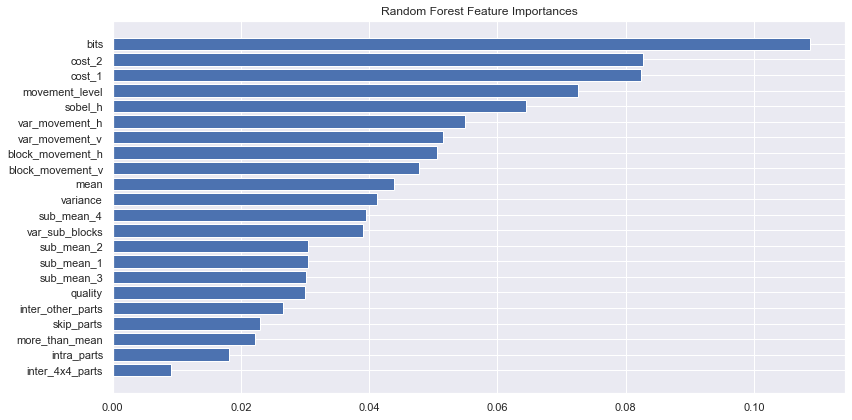

In [103]:
features_to_display = len(feature_names)
sorted_idx = rf_importance.argsort()[-features_to_display:]
fig, ax = plt.subplots(figsize=(12, 6))
y_ticks = np.arange(0, features_to_display)
ax.barh(y_ticks, rf_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")

fig.tight_layout()
plt.show()

## Support Vector Machine

In [110]:
from sklearn.svm import SVC
csv = SVC(random_state=0)
kernel_list = ['rbf','sigmoid','linear']
#gamma_list = ['auto', 'scale']
C_list = [1/10, 1, 10, 100]
param_grid_csv = dict(C=C_list, kernel=kernel_list)
grid = GridSearchCV(csv, param_grid_csv, cv=5, scoring='accuracy', error_score=np.nan, verbose=1,n_jobs=7)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   40.9s
[Parallel(n_jobs=7)]: Done  60 out of  60 | elapsed:  5.0min finished


{'C': 100, 'kernel': 'rbf'}
0.826926472743259
0.8321875
